In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [21]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


# Exploratory Climate Analysis

2016-08-23
('2017-08-23',)


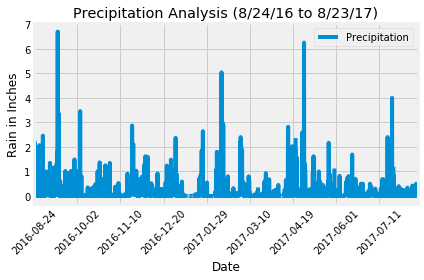

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data
rain_df = pd.DataFrame(rain)
rain_df.set_index('date').head()
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [27]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
best_station = busy_station[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == best_station).all()

[(54.0, 71.66378066378067, 85.0)]

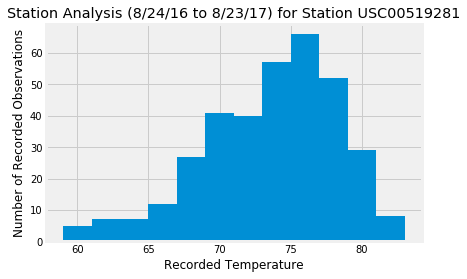

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

## Bonus Challenge Assignment

In [29]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-04-02','2017-04-09')
trip_temps

[(67.0, 74.42, 79.0)]

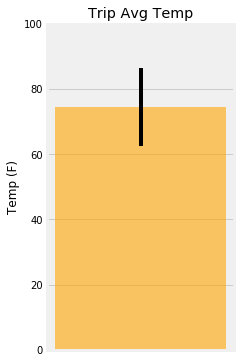

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'orange', alpha=.6)
plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-04-02'
end_date = '2017-04-09'

s = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= start_date)\
.filter(Measurement.date <= end_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for row in s:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()


Station:  USC00516128
    Rainfall:  0.70  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  0.51  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00514830
    Rainfall:  0.16  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00513117
    Rainfall:  0.16  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00519523
    Rainfall:  0.00  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.00  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00517948
    Rainfall:  0.00  
    Locatio

In [37]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurement.date).filter(extract('month', Measurement.date)==trip_month).\
             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date).all()
subquery

[('2010-08-15'),
 ('2011-08-15'),
 ('2012-08-15'),
 ('2013-08-15'),
 ('2014-08-15'),
 ('2015-08-15'),
 ('2016-08-15'),
 ('2017-08-15')]

In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurement.date.label("dates"), func.max(Measurement.tobs).label("max_tobs"),\
                             func.min(Measurement.tobs).label("min_tobs"),func.avg(Measurement.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurement.date)==trip_month).\
                             filter(extract('day', Measurement.date)== i ).group_by(Measurement.date).order_by(Measurement.date)
        results
        for res in results.all():
            print( res)
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)

    
daily_normals()

('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()


,TMAX,TMIN,TAVG
Date,,,
2017-08-01,77.0,72.0,74.5
2017-08-02,83.0,73.0,79.0
2017-08-03,81.0,76.0,79.0
2017-08-04,82.0,77.0,80.0
2017-08-05,82.0,77.0,80.0


<Figure size 648x792 with 0 Axes>

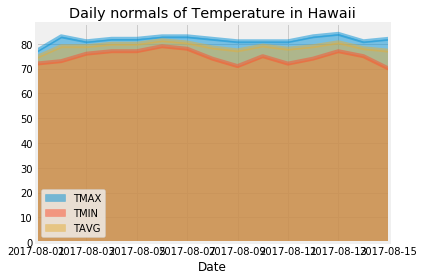

In [43]:
# Plot the daily normals as an area plot with `stacked=False`

fig = plt.figure(figsize=(9, 11))
ax = Daily_normals_df.plot(kind='area', stacked=False, title='Daily normals of Temperature in Hawaii')
ax.set_xlabel('Date')
plt.tight_layout()
plt.savefig('Daily normals of Temperature in Hawaii.png', bbox_inches = 'tight')
plt.show()